<a href="https://colab.research.google.com/github/antoniogss/air_quality/blob/main/sarima_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook imports and packages

In [2]:
import pandas as pd
import numpy as np
import warnings as war
import google.colab as gc
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
import matplotlib.dates as mdates
import itertools
import statsmodels.api as sm

from google.colab import files #Upload files into the notebook
from glob import glob
from datetime import date, time, datetime, timedelta
from functools import reduce
from matplotlib import dates, rcParams
from scipy.stats import linregress
from sklearn import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import KNNImputer
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima import auto_arima
from pylab import rcParams
rcParams['figure.figsize'] = 20,8
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error as mse

war.filterwarnings('ignore')

gc.output.clear()

############################################################
#To import a library that's not in Colaboratory by default,# 
#you can use !pip install or !apt-get install.             #
############################################################

#Google Drive connection

In [3]:
gc.drive.mount('./gdrive/', 
               force_remount=True
              )

gc.output.clear()

#Setting up the working directory

In [4]:
%cd ./gdrive/MyDrive/air_quality/datasets/created_datasets/

dir = '/content/gdrive/MyDrive/air_quality/images/'

/content/gdrive/MyDrive/air_quality/datasets/created_datasets


#Load the csv files into DFs

In [22]:
# assign dataset names
list_A = ['cp','ib', 'inter', 'pq']
list_B = ['_nox_month']*len(list_A)
list_C = ['_o3_8h_month']*len(list_A)

# Use zip
list_of_names_1 = [i + j for i, j in zip(list_A, list_B)]

list_of_names_2 = [i + j for i, j in zip(list_A, list_C)]

list_of_names = list_of_names_1 + list_of_names_2

print("List of dataframes: ", list_of_names)
 
# create empty list
dataframes_list = []
 
# append datasets into the list
for i in range(len(list_of_names)):
    temp_df = pd.read_csv("./"+list_of_names[i]+".csv", 
                          parse_dates=['data_hora']
                          )
    dataframes_list.append(temp_df)

# set the first column as index
for df in dataframes_list:
       df.set_index(df.columns[0], inplace=True)

List of dataframes:  ['cp_nox_month', 'ib_nox_month', 'inter_nox_month', 'pq_nox_month', 'cp_o3_8h_month', 'ib_o3_8h_month', 'inter_o3_8h_month', 'pq_o3_8h_month']


In [23]:
# get the first n elements of a list
cp_nox_month, ib_nox_month, inter_nox_month, pq_nox_month = dataframes_list[0:4] 

# get the last n elements of a list
cp_o3_8h_month, ib_o3_8h_month, inter_o3_8h_month, pq_o3_8h_month = dataframes_list[-4:]

In [24]:
cp_o3_8h_month = cp_o3_8h_month['2012-10':'2021-04'].interpolate(method='time')
inter_o3_8h_month = inter_o3_8h_month['2012-03':'2021-12'].interpolate(method='time')
cp_nox_month = cp_nox_month['2012-10':'2018-12'].interpolate(method='time')
inter_nox_month = inter_nox_month['2012-04':'2020-02'].interpolate(method='time')
pq_nox_month = pq_nox_month.interpolate(method='time')

#SARIMA for Time Series Forecasting

In [136]:
p = d = q = range(0,2)

pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] 

steps = 72

##Capão Redondo

###O3

In [137]:
# #ETS Decomposition
# result_cp = seasonal_decompose(cp_o3_8h_month, model='multiplicative')
# result_cp.plot();

In [138]:
#one year train-test
y_train = cp_o3_8h_month.iloc[:len(cp_o3_8h_month)-12]
y_test = cp_o3_8h_month.iloc[len(cp_o3_8h_month)-12:]

In [139]:
# print('Examples of parameter combinations for Seasonal Arima:')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
# print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[5]))

In [140]:
#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

In [141]:
a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

In [142]:
# #Fitting the final model based on the lowest AIC

# model = sm.tsa.statespace.SARIMAX(y_train,
#                                   order = a,
#                                   seasonal_order = b,
#                                   enforce_stationarity=False,
#                                   enforce_invertibility=False)

# model_aic = model.fit()
# print(model_aic.summary().tables[1])

In [143]:
# #Model diagnostic plot to check residuals

# model_aic.plot_diagnostics();

In [144]:
forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_cp_o3 = forecast.predicted_mean
ci_cp_o3 = forecast.conf_int()

# #Observed Plot
# fig = cp_o3_8h_month.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('O3')
# fig.fill_between(ci_cp_o3.index,
#                  ci_cp_o3.iloc[:, 0],
#                  ci_cp_o3.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_cp_o3.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###NO

In [145]:
y = cp_nox_month['NO']
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

 #Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_cp_no = forecast.predicted_mean
ci_cp_no = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('NO')
# fig.fill_between(ci_cp_no.index,
#                  ci_cp_no.iloc[:, 0],
#                  ci_cp_no.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_cp_no.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###NO2

In [146]:
y = cp_nox_month['NO2']
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_cp_no2 = forecast.predicted_mean
ci_cpno2 = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('NO2')
# fig.fill_between(ci_cpno2.index,
#                  ci_cpno2.iloc[:, 0],
#                  ci_cpno2.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_cp_no2.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###Forecasting

In [147]:
ax = fig.add_subplot(111)

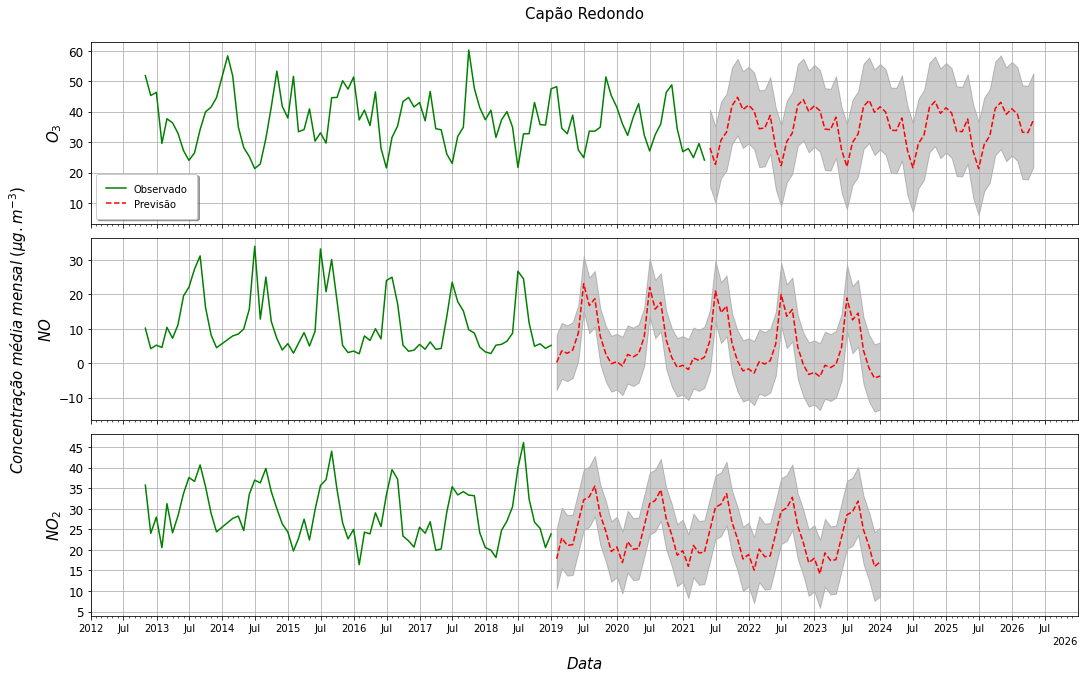

In [148]:
y_1 = cp_o3_8h_month
y_2 = cp_nox_month['NO']
y_3 = cp_nox_month['NO2']

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                    ncols=1, 
                                    sharex=True,
                                  #  sharey=True, 
                                    figsize=(16,10)
                                    )

####

ax1.plot(y_1, label='Observado', color='green')

ax1.plot(predictions_cp_o3['2021-05':], '--r', label='Previsão', color='red')

ax1.fill_between(ci_cp_o3['2021-05':].index,
                 ci_cp_o3['2021-05':].iloc[:, 0],
                 ci_cp_o3['2021-05':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='green')

ax2.plot(predictions_cp_no['2019-01':], '--r', label='Previsto', color='red')

ax2.fill_between(ci_cp_no['2019-01':].index,
                 ci_cp_no['2019-01':].iloc[:, 0],
                 ci_cp_no['2019-01':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='green')

ax3.plot(predictions_cp_no2['2019-01':], '--r', label='Previsto', color='red')

ax3.fill_between(ci_cpno2['2019-01':].index,
                 ci_cpno2['2019-01':].iloc[:, 0],
                 ci_cpno2['2019-01':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


ax1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='lower left')
ax1.set_title('Capão Redondo\n',fontsize=15)
ax1.set_ylabel('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

# ax2.legend()
# ax2.set_title('$NO$',fontsize=15)
ax2.set_ylabel('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

# ax3.legend()
# ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_ylabel('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;mensal\;(µg.m^{-3})$\n\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'cp_prediction.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Ibirapuera

###O3

In [149]:
y = ib_o3_8h_month
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_ib_o3 = forecast.predicted_mean
ci_ib_o3 = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('O3')
# fig.fill_between(ci_ib_o3.index,
#                  ci_ib_o3.iloc[:, 0],
#                  ci_ib_o3.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_ib_o3.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###NO

In [150]:
y = ib_nox_month['NO']
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_ib_no = forecast.predicted_mean
ci_ib_no = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('NO')
# fig.fill_between(ci_ib_no.index,
#                  ci_ib_no.iloc[:, 0],
#                  ci_ib_no.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_ib_no.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###NO2

In [151]:
y = ib_nox_month['NO2']
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_ib_no2 = forecast.predicted_mean
ci_ib_no2 = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('NO2')
# fig.fill_between(ci_ib_no2.index,
#                  ci_ib_no2.iloc[:, 0],
#                  ci_ib_no2.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_ib_no2.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###Forecasting

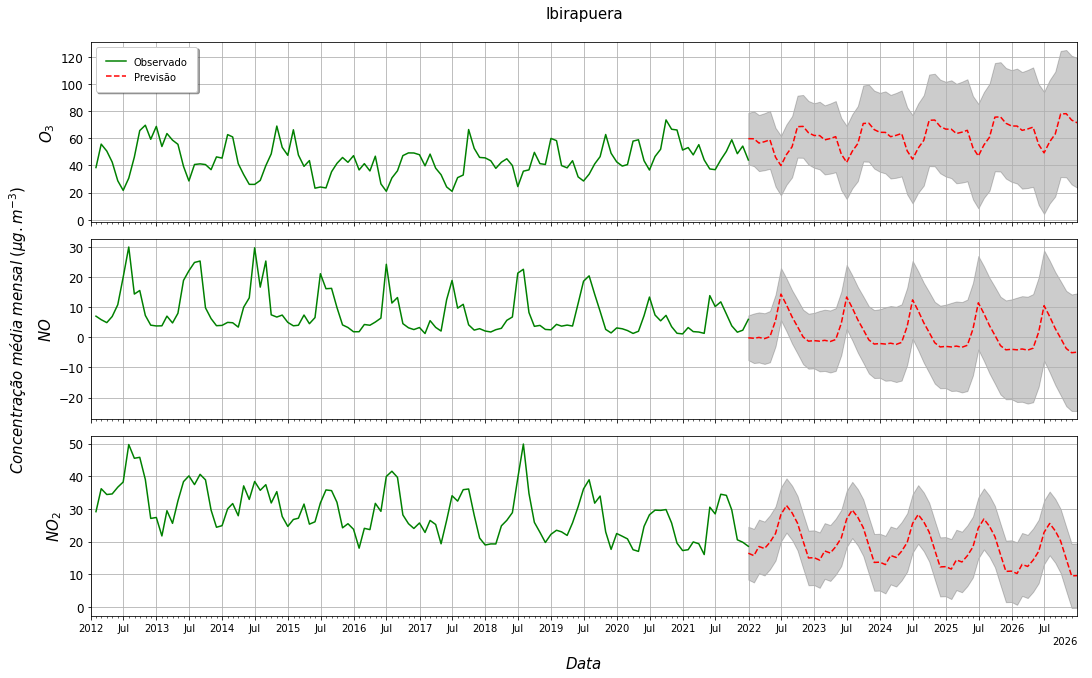

In [168]:
y_1 = ib_o3_8h_month
y_2 = ib_nox_month['NO']
y_3 = ib_nox_month['NO2']

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                    ncols=1, 
                                    sharex=True,
                                  #  sharey=True, 
                                    figsize=(16,10)
                                    )

####

ax1.plot(y_1, label='Observado', color='green')

ax1.plot(predictions_ib_o3['2021-12':], '--r', label='Previsão', color='red')

ax1.fill_between(ci_ib_o3['2021-12':].index,
                 ci_ib_o3['2021-12':].iloc[:, 0],
                 ci_ib_o3['2021-12':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='green')

ax2.plot(predictions_ib_no['2021-12':], '--r', label='Previsto', color='red')

ax2.fill_between(ci_ib_no['2021-12':].index,
                 ci_ib_no['2021-12':].iloc[:, 0],
                 ci_ib_no['2021-12':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='green')

ax3.plot(predictions_ib_no2['2021-12':], '--r', label='Previsto', color='red')

ax3.fill_between(ci_ib_no2['2021-12':].index,
                 ci_ib_no2['2021-12':].iloc[:, 0],
                 ci_ib_no2['2021-12':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


ax1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='upper left')
ax1.set_title('Ibirapuera\n',fontsize=15)
ax1.set_ylabel('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

# ax2.legend()
# ax2.set_title('$NO$',fontsize=15)
ax2.set_ylabel('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

# ax3.legend()
# ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_ylabel('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;mensal\;(µg.m^{-3})$\n\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'cp_prediction.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Interlagos

###O3

In [153]:
y = inter_o3_8h_month
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_inter_o3 = forecast.predicted_mean
ci_inter_o3 = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('O3')
# fig.fill_between(ci_inter_o3.index,
#                  ci_inter_o3.iloc[:, 0],
#                  ci_inter_o3.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_inter_o3.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###NO

In [154]:
y = inter_nox_month['NO']
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_inter_no = forecast.predicted_mean
ci_inter_no = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('NO')
# fig.fill_between(ci_inter_no.index,
#                  ci_inter_no.iloc[:, 0],
#                  ci_inter_no.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_inter_no.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###NO2

In [155]:
y = inter_nox_month['NO2']
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_inter_no2 = forecast.predicted_mean
ci_inter_no2 = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('NO2')
# fig.fill_between(ci_inter_no2.index,
#                  ci_inter_no2.iloc[:, 0],
#                  ci_inter_no2.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_inter_no2.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###Forecasting

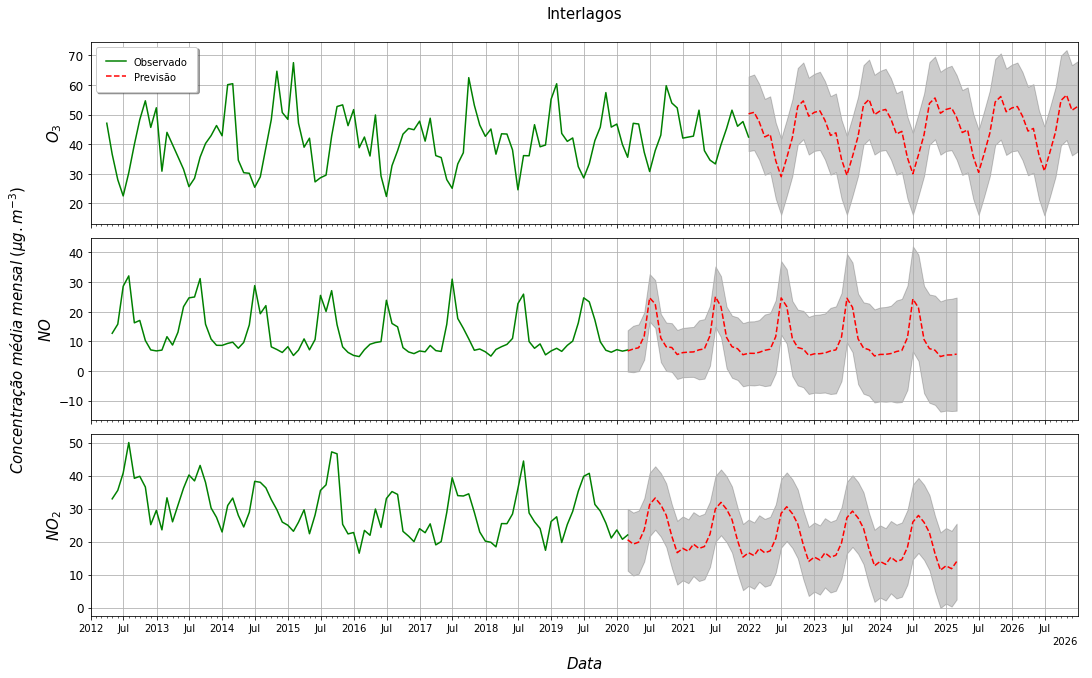

In [156]:
y_1 = inter_o3_8h_month
y_2 = inter_nox_month['NO']
y_3 = inter_nox_month['NO2']

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                    ncols=1, 
                                    sharex=True,
                                  #  sharey=True, 
                                    figsize=(16,10)
                                    )

####

ax1.plot(y_1, label='Observado', color='green')

ax1.plot(predictions_inter_o3['2021-12':], '--r', label='Previsão', color='red')

ax1.fill_between(ci_inter_o3['2021-12':].index,
                 ci_inter_o3['2021-12':].iloc[:, 0],
                 ci_inter_o3['2021-12':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='green')

ax2.plot(predictions_inter_no['2020-02':], '--r', label='Previsto', color='red')

ax2.fill_between(ci_inter_no['2020-02':].index,
                 ci_inter_no['2020-02':].iloc[:, 0],
                 ci_inter_no['2020-02':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='green')

ax3.plot(predictions_inter_no2['2020-02':], '--r', label='Previsto', color='red')

ax3.fill_between(ci_inter_no2['2020-02':].index,
                 ci_inter_no2['2020-02':].iloc[:, 0],
                 ci_inter_no2['2020-02':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


ax1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='upper left')
ax1.set_title('Interlagos\n',fontsize=15)
ax1.set_ylabel('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

# ax2.legend()
# ax2.set_title('$NO$',fontsize=15)
ax2.set_ylabel('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

# ax3.legend()
# ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_ylabel('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;mensal\;(µg.m^{-3})$\n\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'cp_prediction.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Parque Dom Pedro II

###O3

In [157]:
y = pq_o3_8h_month
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_pq_o3 = forecast.predicted_mean
ci_pq_o3 = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('O3')
# fig.fill_between(ci_pq_o3.index,
#                  ci_pq_o3.iloc[:, 0],
#                  ci_pq_o3.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_pq_o3.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###NO

In [158]:
y = pq_nox_month['NO']
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_pq_no = forecast.predicted_mean
ci_pq_no = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('NO')
# fig.fill_between(ci_pq_no.index,
#                  ci_pq_no.iloc[:, 0],
#                  ci_pq_no.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_pq_no.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###NO2

In [159]:
y = pq_nox_month['NO2']
y_train = y.iloc[:len(y)-12]
y_test = y.iloc[len(y)-12:]

#Two loops: 1) pdq and 2) 4 parameters for seasonal component

metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=pm,
                                          seasonal_order = pm_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_aic = model.fit()
        # print('ARIMA{}x{} - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
        metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
    except:
      continue

a = min(metric_aic_dict.items(), key=lambda x: x[1])[0][0] 
b = min(metric_aic_dict.items(), key=lambda x: x[1])[0][1]

#Fitting the final model based on the lowest AIC

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order = a,
                                  seasonal_order = b,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_aic = model.fit()

forecast = model_aic.get_forecast(steps=steps)

#predictions and confidence interval
predictions_pq_no2 = forecast.predicted_mean
ci_pq_no2 = forecast.conf_int()

# #Observed Plot
# fig = y.plot(label='Observed')
# fig.set_xlabel('Date')
# fig.set_ylabel('NO2')
# fig.fill_between(ci_pq_no2.index,
#                  ci_pq_no2.iloc[:, 0],
#                  ci_pq_no2.iloc[:, 1],
#                  color='k',
#                  alpha=.2
#                 )

# #Prediction Plot
# predictions_pq_no2.plot(ax=fig,
#                  label='Predictions',
#                  alpha=.7,)

# plt.legend()

# plt.show()

###Forecasting

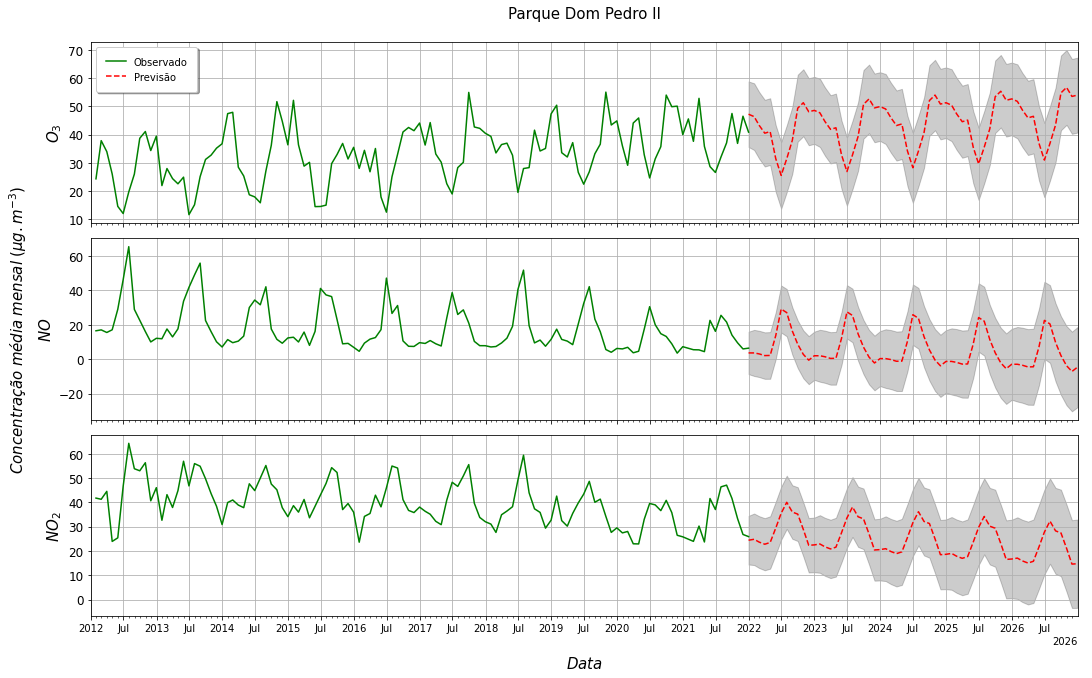

In [166]:
y_1 = pq_o3_8h_month
y_2 = pq_nox_month['NO']
y_3 = pq_nox_month['NO2']

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                    ncols=1, 
                                    sharex=True,
                                  #  sharey=True, 
                                    figsize=(16,10)
                                    )

####

ax1.plot(y_1, label='Observado', color='green')

ax1.plot(predictions_pq_o3['2021-12':], '--r', label='Previsão', color='red')

ax1.fill_between(ci_pq_o3['2021-12':].index,
                 ci_pq_o3['2021-12':].iloc[:, 0],
                 ci_pq_o3['2021-12':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='green')

ax2.plot(predictions_pq_no['2021-12':], '--r', label='Previsto', color='red')

ax2.fill_between(ci_pq_no['2021-12':].index,
                 ci_pq_no['2021-12':].iloc[:, 0],
                 ci_pq_no['2021-12':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='green')

ax3.plot(predictions_pq_no2['2021-12':], '--r', label='Previsto', color='red')

ax3.fill_between(ci_pq_no2['2021-12':].index,
                 ci_pq_no2['2021-12':].iloc[:, 0],
                 ci_pq_no2['2021-12':].iloc[:, 1],
                 color='k',
                 alpha=.2
                )

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


ax1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
ax1.set_title('Parque Dom Pedro II\n',fontsize=15)
ax1.set_ylabel('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

# ax2.legend()
# ax2.set_title('$NO$',fontsize=15)
ax2.set_ylabel('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

# ax3.legend()
# ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_ylabel('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2026,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;mensal\;(µg.m^{-3})$\n\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'cp_prediction.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#RMSE table

In [161]:
# rmse_cp_o3 = round(np.sqrt(mse(predictions_cp_o3,y_test)),2)
# rmse_cp_no = round(np.sqrt(mse(predictions_cp_no,y_test)),2)
# rmse_cp_no2 = round(np.sqrt(mse(predictions_cp_no2,y_test)),2)
# rmse_ib_o3 = round(np.sqrt(mse(predictions_ib_o3,y_test)),2)
# rmse_ib_no = round(np.sqrt(mse(predictions_ib_no,y_test)),2)
# rmse_ib_no2 = round(np.sqrt(mse(predictions_ib_no2,y_test)),2)
# rmse_inter_o3 = round(np.sqrt(mse(predictions_inter_o3,y_test)),2)
# rmse_inter_no = round(np.sqrt(mse(predictions_inter_no,y_test)),2)
# rmse_inter_no2 = round(np.sqrt(mse(predictions_inter_no2,y_test)),2)
# rmse_pq_o3 = round(np.sqrt(mse(predictions_pq_o3,y_test)),2)
# rmse_pq_no = round(np.sqrt(mse(predictions_pq_no,y_test)),2)
# rmse_pq_no2 = round(np.sqrt(mse(predictions_pq_no2,y_test)),2)

In [162]:
# # initialize data of lists.
# data = {'Estação': ['Capão Redondo', 'Ibirapuera', 'Interlagos', 'Parque Dom Pedro II'],
#         'O3': [rmse_cp_o3, rmse_ib_o3, rmse_inter_o3, rmse_pq_o3],
#         'NO': [rmse_cp_no, rmse_ib_no, rmse_inter_no, rmse_pq_no],
#         'NO2': [rmse_cp_no2, rmse_ib_no2, rmse_inter_no2, rmse_pq_no2]}
  
# # Create DataFrame
# df = pd.DataFrame(data)
  
# # Print the output.
# df